## Introduccion 
Eigenfaces (en español caras propias) es el nombre dado a un conjunto de autovectores cuando se utiliza en el problema de visión artificial del reconocimiento de rostros humanos. Matthew Turk y Alex Pentland lo propusieron en su paper en la clasificación de caras.

Esta notebook muestra como hacer el cálculo del Análisis en Componentes Principales para los datos de los rostros, y luego aplicarlos para la reducción del espacio. Con este nuevo espacio se realizan dos tareas: reconstrucción y clasificación.

In [3]:
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold

Definición de funciones 

In [4]:
def splitDataset(data, label):
    # split dataset en entrenamiento y test
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train, test in skf.split(data.T, label.T):
        break
    train_data = data[:,train]
    train_lab = label[:,train]
    test_data = data[:,test]
    test_lab = label[:,test]
    
    return train_data, train_lab, test_data, test_lab

In [5]:
def showPic(data, idx, dx=38):
    #idx es el indice de la imagen a mostrar
    #dx es el tamaño de la imagen
    # graficamos una rostro
    v = data[:,idx] # todas las filas de la columna idx
    m = v.reshape((dx,dx)).T # reacomodamos el vector en una matriz dx x dx para que tenga los pixeles de la imagen y la trasponemos 
    plt.imshow(m, cmap=plt.cm.gray) # graficamos la matriz como una imagen en escala de grises


La lectura del archivo de datos nos devuelve dos matrices, una correspondiente a las imágenes de los rostros y la otra a un label que indica a cual
persona pertenece la imágen.

<img src="image_vector.png" />

Como vemos en la figura, las imágenes se convirtieron a vector, con N=38 para este set de datos.

In [6]:
mat = sio.loadmat('matlab/base_40_38_10.mat')
# data es una matriz de 1444 x 380.
# Corresponde a figuras de caras de tamanio 38x38 pixeles
data = mat['data']
label = mat['label']
# extraemos la dimensionalidad de data, donde n es la cantidad de ejemplos, y d la dimensión del espacio.
d, n = data.shape

## ACP

Primero centramos los valores de las imágenes, restando la media.
Luego calculamos la matriz de covarianzas:


$C = \frac{1}{n} \sum_{i=1}^n (x_i - \mu) (x_i - \mu)^{T}$

Finalmente encontramos los autovalores y autovectores de esta matriz, los cuales ordenamos de mayor a menor valor.

In [21]:
def calculoACP(data):
    d, n = data.shape # d, 1444 es la dimensión de los datos, n, 380 es la cantidad de datos
    m=np.mean(data, axis=1) #calculamos la media de los datos por columnas, para cada dimensión (x1, ... xd)    
    # np.tile repite la media m, n veces, para que tenga la misma dimensión que data
    # luego la restamos a data
    X = data - np.tile(m.reshape((len(m), 1)), (1, n))
    # calculamos la matriz de covarianza, que es X*X^T/n ya que 
    Mcov = np.dot(X,X.T) / n # Covariance Matrix

    D, V = np.linalg.eigh(Mcov)

    # ordenamos los autovalores de mayor a menor
    idx = np.argsort (- D )
    D = D[idx]
    V = V[:, idx]

    return D, V, X, m

Descomposición de Varianza: La matriz de covarianza Σ puede ser descompuesta en términos de sus autovectores y autovalores. Esta descomposición muestra cómo la varianza de los datos se distribuye a lo largo de diferentes direcciones en el espacio de características.

Máxima Variabilidad: El autovector con el mayor autovalor corresponde a la dirección en la que los datos tienen la máxima variabilidad. El segundo mayor autovalor corresponde a la segunda mayor dirección de variabilidad, y así sucesivamente. Estos autovectores son las "direcciones principales" de variabilidad.



**Observación:** Si una matriz es ortonormal, su matriz de covarianza va a ser justamente la identidad/n ya que todas las columnas son lineales independientes, entonces varían independientemente. Sólo se relacionan consigo mismas.

In [22]:
D, V, data_ref, m = calculoACP(data)

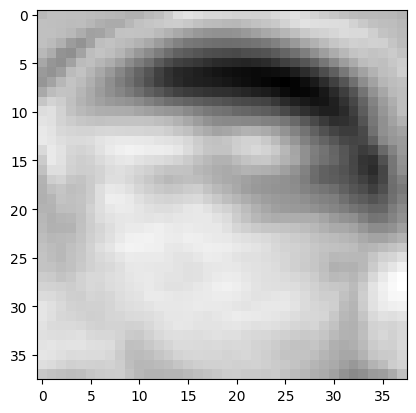

In [9]:
showPic(V, 0)

El espacio de proyección del ACP esta compuesto por el vector V que es de tamaño $n \times n$.

El próximo paso busca la reducción del espacio de proyección, para quedarnos con aquellos autovectores en V que acumulen la mayor cantidad de información posible en las distintas direcciones.

Para ello se hace un cómputo de la varianza acumulada en el vector D, y se selecciona una cantidad que signifique representar un 95 % de la información.

Cantidad de autovectores de representación al 95 %:  94


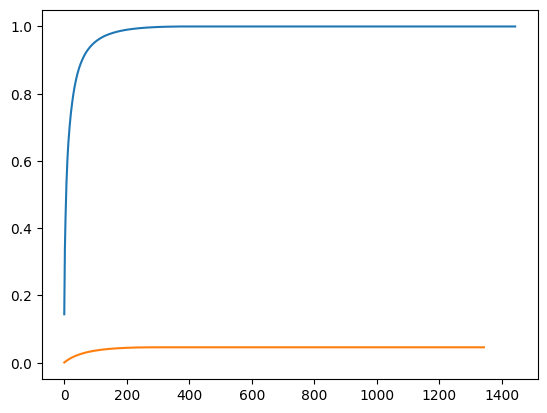

In [10]:
ratio = np.cumsum(D) / np.sum(D)
plt.plot(ratio)
plt.plot(np.cumsum(D[100:])/ np.sum(D))
x = np.where(ratio > 0.95)[0]
M = x[0]

print('Cantidad de autovectores de representación al 95 %: ', M)


## RECONSTRUCCIÓN

El hecho que quedarse con menos autovectores para la proyección del espacio, conlleva a una reducción de almacenamiento de la información, pero al mismo tiempo a cometer un error al tratar de reconstruir la imagen original.

En este tramo de código representamos visualmente la imagen original y la reconstruida con M autovectores.

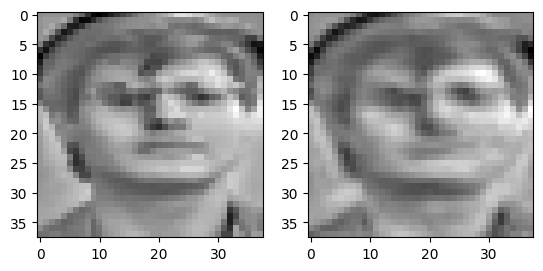

In [11]:
# Reconstruccion
im_orig = data_ref[:,0]
cpM = im_orig @ V[:,0:M]
im_rec = V[:,0:M] @ cpM 

fig, axes = plt.subplots(1,2)
axes[0].imshow(im_orig.reshape((38,38)).T, cmap=plt.cm.gray)
axes[1].imshow(im_rec.reshape((38,38)).T, cmap=plt.cm.gray)
plt.show()

## CLASIFICACIÓN

La tarea de clasificación en predecir a quien de las personas de la base de conocimientos pertenece un rostro de testing. Esto lo vamos a realizar gracias a proyectar el rostro de entrada al espacio de ACP y calcular por distancias, cual es rostro más cercano.

En primer lugar separamos 

In [12]:
# clasificacion
train_data, train_lab, test_data, test_lab = splitDataset(data, label)
Dt, Vt, train_ref, m = calculoACP(train_data)

(1444,)


Cantidad de autovectores de representación al 95 % de la base de entrenamiento:  83


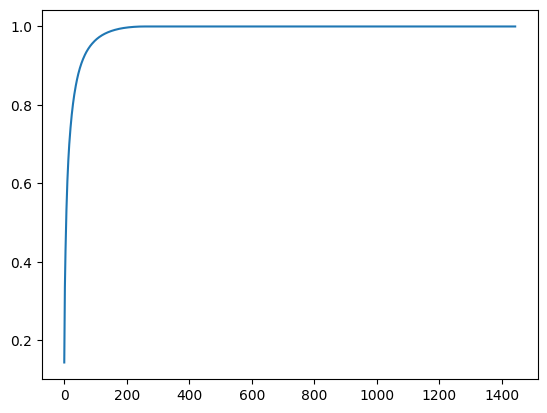

In [13]:
ratio = np.cumsum(Dt) / np.sum(Dt)
plt.plot(ratio)
x = np.where(ratio > 0.95)[0]
M = x[0]
print('Cantidad de autovectores de representación al 95 % de la base de entrenamiento: ', M)

In [14]:
data_clf = train_ref.T @ Vt[:,0:M]   # proyectamos a la base de entrenamiento, de los cuales conocemos a que persona pertenece

input_test = test_data[:,0] # vamos a clasificar el primer sujeto de la base de test
test_acp = (input_test - m) @ Vt[:,0:M]    # le resto la media y proyecto en el espacio reducido de Vt
Q = np.tile(test_acp.reshape((1,-1)), (data_clf.shape[0], 1))  
dist = np.linalg.norm(data_clf - Q, axis=1)    # calculo las distancias a cada una de las imágenes de conocimientos proyectadas en el espacio ACP.
y = np.argmin(dist)                             # clasificar por el más cercano

if test_lab[0][0] == train_lab[0][y]:
    print('Clasificacion correcta')
else:
    print('clasificacion incorrecta')

Clasificacion correcta
